# OSIC, but image props

The other file is for metadata, this one's for image property stuff. Mainly to demonstrate lots of multiprocessing capabilities.

In [1]:
from k1lib.imports import *
from k1lib.bioinfo.cli import *
import pydicom

In [2]:
["abc", "ab"] | applyMp(lambda x: len(x)) | toList()

[3, 2]

In [3]:
#base = "/home/kelvin/hdd/data/osic-pulmonary-fibrosis-progression"
base = "/home/kelvin/repos/labs/data/osic-pulmonary-fibrosis-progression"

In [4]:
file = ls(base) | item() | ls() | item() | ls() | item()
f = pydicom.read_file(file)
img = torch.tensor(f.pixel_array.astype(np.float32))
img.shape

torch.Size([512, 512])

All 512 pixels?

In [5]:
%%time
h, w = ls(base) | item() | ls() | deref()\
| applyMp(ls() | apply(lambda dcmF: pydicom.read_file(dcmF).pixel_array.shape) | toList())\
| joinStreams() | transpose() | deref()

Corrupt JPEG data: bad Huffman code
Unsupported marker type 0xfa


CPU times: user 1.36 s, sys: 100 ms, total: 1.46 s
Wall time: 4.29 s


In [6]:
w | count() | ~sort() | display(None)

24050   512    73%   
8078    768    24%   
536     888    2%    
338     632    1%    
24      1302   0%    


In [7]:
h | count() | ~sort() | display(None)

24050   512    73%   
8078    768    24%   
338     632    1%    
319     733    1%    
71      734    0%    
57      752    0%    
31      843    0%    
30      788    0%    
28      1100   0%    
24      1302   0%    


Oh god why can't the images be even square??? Like why do you want me to suffer??

How about pixel value range? First let's grab the mins and maxes first

In [8]:
def patientMinMax(patientUrl):
    import pydicom
    from k1lib.bioinfo.cli import ls, apply, deref
    def f(dcmF):
        img = pydicom.read_file(dcmF).pixel_array
        return img.min(), img.max()
    return patientUrl | ls() | apply(f) | deref()

In [9]:
%%time
minMax = ls(base) | item() | ls() | applyMp(patientMinMax)
min_, max_ = minMax | joinStreams() | transpose() | (toMin() + toMax()); min_, max_

Corrupt JPEG data: bad Huffman code
Unsupported marker type 0xfa


CPU times: user 252 ms, sys: 71.4 ms, total: 324 ms
Wall time: 5.8 s


(-31860, 32747)

Dear god why is the range so fking big? So let's check the histograms then?

In [10]:
def patientHist(patientUrl, min_, max_):
    import pydicom, torch, numpy as np
    from k1lib.bioinfo.cli import ls
    def f(dcmF):
        img = pydicom.read_file(dcmF).pixel_array
        return img.min(), img.max()
    dcms = patientUrl | ls()
    histT = torch.zeros(300)
    for dcmF in dcms:
        img = torch.from_numpy(pydicom.read_file(dcmF).pixel_array.astype(np.float32))
        histT += torch.histc(img, 300, min_, max_)
    return histT

In [11]:
%%time
hists = ls(base) | item() | ls() | applyMp(patientHist, min_, max_) | deref()

Corrupt JPEG data: bad Huffman code
Unsupported marker type 0xfa


CPU times: user 231 ms, sys: 81.7 ms, total: 312 ms
Wall time: 9.77 s


In [12]:
histT = torch.zeros(300)
for h in hists: histT += h
r = torch.linspace(min_, max_, 300)

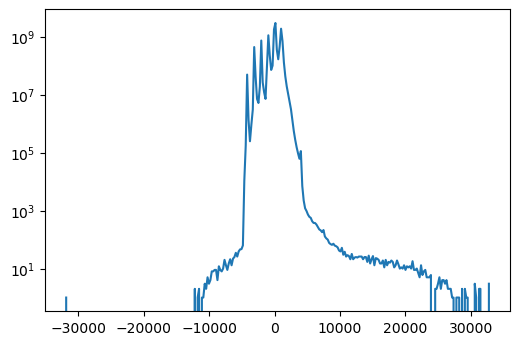

In [13]:
plt.plot(r, histT); plt.yscale("log");

(tensor([-4418.2310, -3770.0005, -3121.7695, -2473.5391, -1825.3083, -1177.0775,
          -528.8467,   119.3841,   767.6149,  1415.8467,  2064.0774,  2712.3081,
          3360.5388]),
 tensor([1.7623e+05, 2.4824e+05, 4.4318e+08, 5.2074e+06, 2.6904e+07, 9.1991e+07,
         7.1937e+07, 2.9974e+09, 4.6301e+08, 1.3062e+08, 1.0835e+07, 1.3098e+06,
         1.5507e+05]))

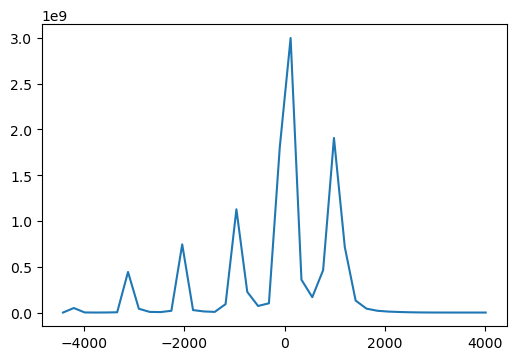

In [14]:
b = histT > 1e5; plt.plot(r[b], histT[b]); r[b][::3], histT[b][::3]

Very interesting. Bulk of pixel values are in the $[-4300, 3500]$ region, and with frequency $10^7$ to $10^9$. Why is there a plateau at the 40-100 region? Just background noise then?

This seems to agree with the above one:

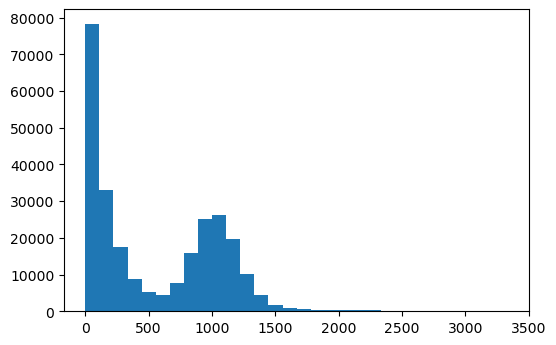

In [15]:
plt.hist(f.pixel_array.flatten(), bins=30);

And for a slice:

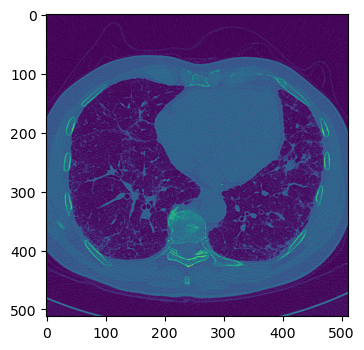

In [16]:
plt.imshow(f.pixel_array);

The purple part between the circle and the square is sort of all 2048:

In [17]:
all(f.pixel_array[:20, :20].flatten() == -2048)

False

And the "air" part above is sort of around -1000 to -1200

In [18]:
f.pixel_array[20:80, 200:300]

array([[  12,   66,    4, ...,   22,  177,    0],
       [   0,  211,  235, ...,    0,  137,  112],
       [   4,   46,  179, ...,    0,    0,  192],
       ...,
       [ 713,  948, 1065, ...,   84,   71,  233],
       [ 949,  987, 1014, ...,  745,  910, 1155],
       [ 730,  899,  920, ..., 1130, 1214, 1272]], dtype=uint16)

## Make scales look nice

Here, we're looking over 10000 different images from all over. I'm really hesitant to use all 32k images, as that's quite slow, and 1000 images is just as representative.

In [22]:
%%time
crissCross = applyS(lambda tensors: torch.crissCross(*tensors))
bounds = base | ls() | item() | ls() | ls().all() | joinStreams() | randomize(None)\
| batched(100) | head(30) | (
    applyMp(lambda dcmF: torch.tensor(pydicom.read_file(dcmF).pixel_array.flatten()[::128].astype(np.float32)))\
    | crissCross
).all() | crissCross

Corrupt JPEG data: bad Huffman code
Unsupported marker type 0xfa


CPU times: user 37.2 s, sys: 4.18 s, total: 41.4 s
Wall time: 5.18 s


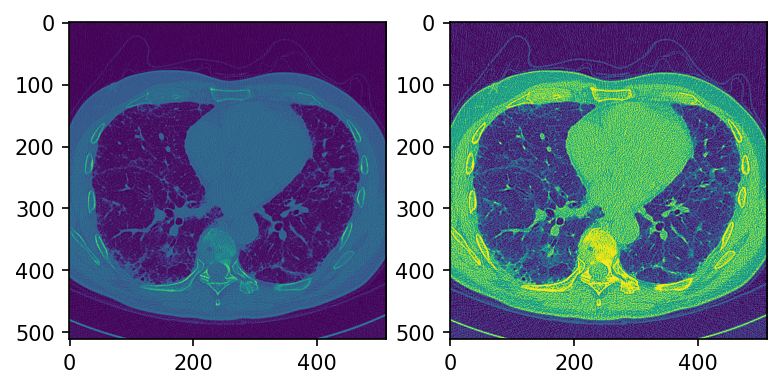

In [20]:
def gen(img=None):
    if img is None:
        f = pydicom.read_file(ls(base) | item() | ls() | ls().all() | joinStreams() | randomize() | item())
        img = torch.tensor(f.pixel_array.astype(np.float32))
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150)
    ax1.imshow(img); ax2.imshow(img.histScaled(bounds=bounds));
gen()

The transformed image looks a million times better!

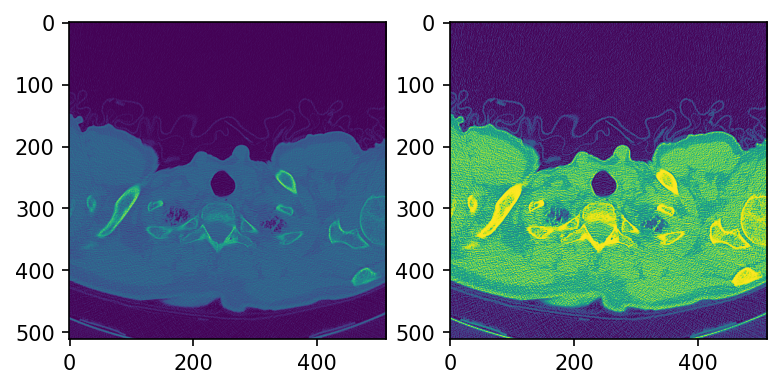

In [23]:
gen()

Like woah. Rescaled images looks so, so much better. Details are so crisp!